# Sensitivity analysis

### Todo:

* variance of parameter vs variance of other plotten (x axis: angle weight, y axis: several lines, variation of each parameter, so one can see higher angle costs on average causes higher planungskosten)
* scatter plot matrix: immer two together considered

### General notes:

* Bau: Red, Planung: Green, Umwelt: Blue

In [1]:
import matplotlib.pyplot as plt
import numpy as np
# import networkx as nx
import os
import pandas as pd
import time
import json
import pickle
import seaborn as sb

In [29]:
base_path = "../../outputs/de_presentation/weight_sensitivity_0905"
MIN_H = 50
MAX_H = 80

COLS = ["green", "orange", "red"] 
COL_NAMES = ["Angle", "Edge", "Height", "Resistance", "Umwelt"]

In [30]:
unique_ids = [f for f in os.listdir(base_path) if f[-3:]=="csv" and f[:2]=="po"]

In [31]:
table_list = [pd.read_csv(os.path.join(base_path, file_id)) for file_id in unique_ids]

In [32]:
# need to swap columns to match the weights
for i in range(len(table_list)):
    table_list[i] = table_list[i][['X', 'Y', 'X_raw', 'Y_raw', 'angle costs','edge costs', 'heights', 'resistance']]

In [33]:
id_params = [((fn.split("sensitivity_")[1]).split(".")[0]).split("_") for fn in unique_ids]
id_params = np.array([[int(a[1:]) for a in liste] for liste in id_params])

In [34]:
id_params

array([[ 9,  1,  5],
       [ 9,  9,  5],
       [ 1,  9,  5],
       [ 1,  1,  5],
       [ 1,  1, 25],
       [ 9,  9, 25],
       [ 9,  1, 25],
       [ 1,  9, 25]])

In [27]:
# READ DATA
with open("../data/de_data_1_1.dat", "rb") as infile:
    data = pickle.load(infile)
    (instance, edge_cost, instance_corr, config) = data
disp_inst = np.squeeze((np.moveaxis(instance, 0, -1)[:, :, :3] * 255).astype(np.uint8))

In [8]:
def plot_paths(inst, paths, col="blue"):
    # plt.figure(figsize=(20,10))
    plt.imshow(np.swapaxes(inst, 1, 0))
    for path in paths:
        path = np.asarray(path)
        plt.plot(path[:,0], path[:,1], c=col)
    # plt.show()
def group_by_col(id_params, value, col=0):
    id_params = np.asarray(id_params)
    inds = np.where(id_params[:, col]==value)[0]
    return inds
def return_path_subset(table_list, inds):
    return [np.asarray(table_list[i][["X_raw", "Y_raw"]]) for i in inds]

## Plot all paths:

In [ ]:
paths = return_path_subset(table_list, range(len(table_list)))
plot_paths(disp_inst, paths)

## NEW for de instance: plot yellow and red comparison

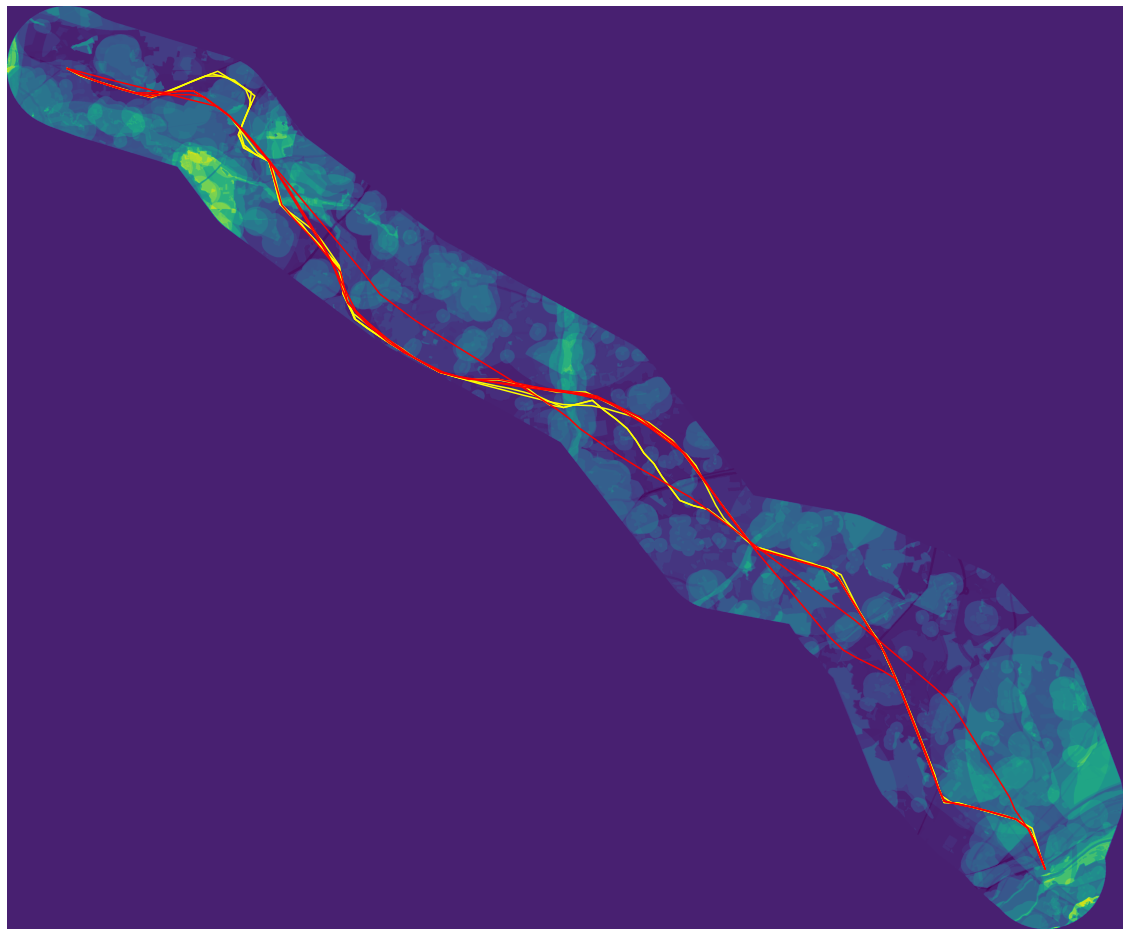

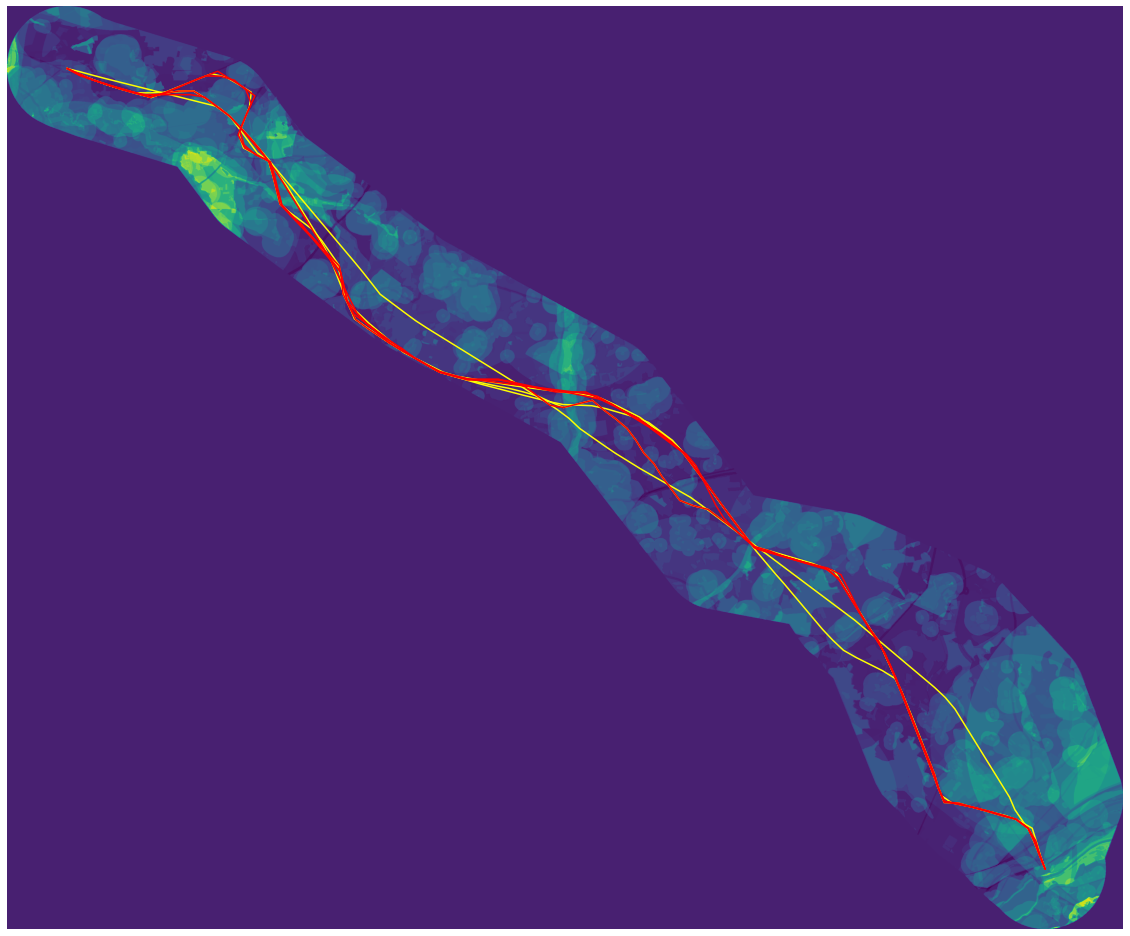

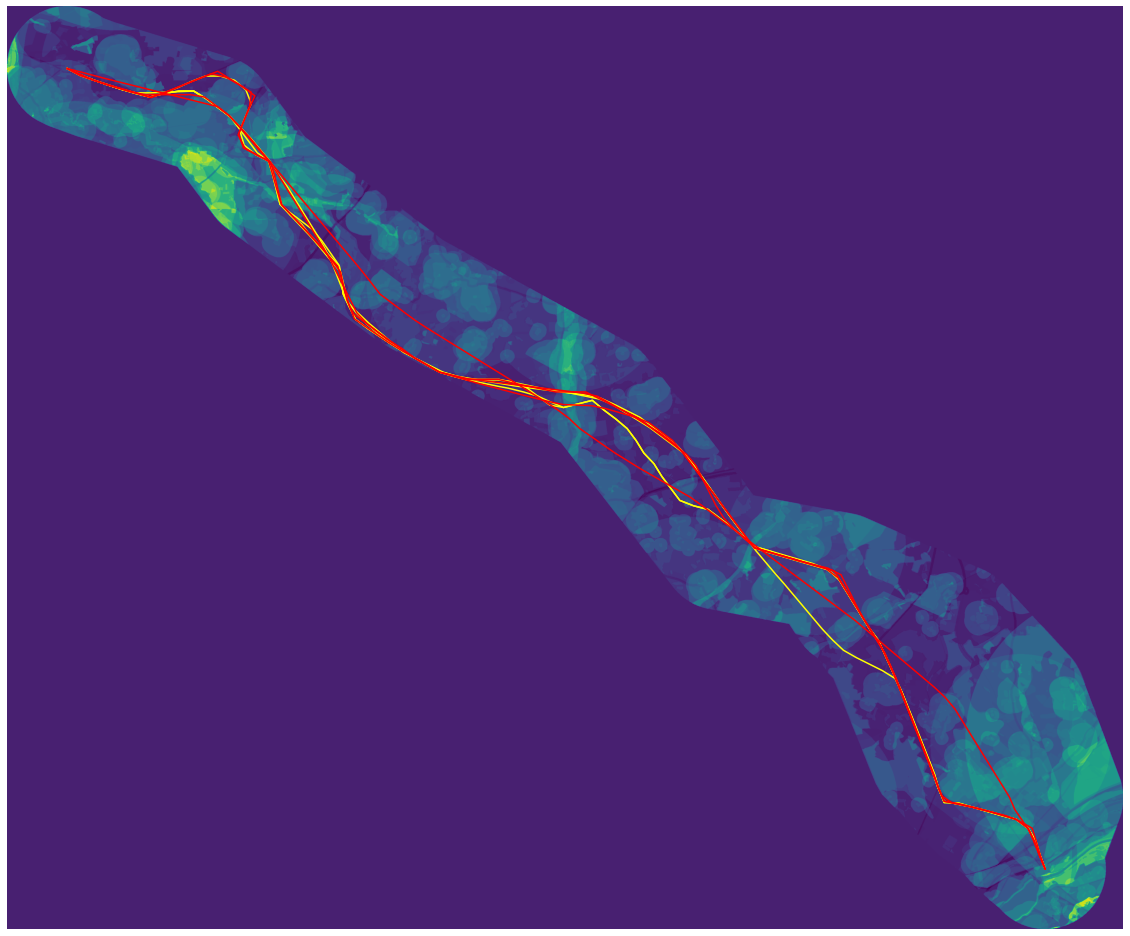

In [36]:
NAMES = ["Angle", "Cable", "Power"]
for column in range(3):
    plt.figure(figsize=(20,20))
    
    weights = np.unique(id_params[:, column])

    inds = group_by_col(id_params, weights[0], col=column)
    paths = return_path_subset(table_list, inds)
    plot_paths(disp_inst, paths, col="yellow")
    
    inds = group_by_col(id_params, weights[1], col=column)
    paths = return_path_subset(table_list, inds)
    plot_paths(disp_inst, paths, col="red")
    # plt.title(NAMES[column], fontsize=25)
    plt.axis("off")
    plt.savefig("../../outputs/de_presentation/"+NAMES[column]+"_19.png",bbox_inches='tight' )
    plt.show()


### Plot how often a cell is crossed

In [ ]:
disp_inst_3D = np.tile(np.expand_dims(disp_inst, 2), 3)

In [ ]:
mult_factors = [20, 8]
buffer = 5
for params, table in zip(id_params, table_list):
    path = np.asarray(table[["X_raw", "Y_raw"]]).astype(int)
    for p in path:
        for i in range(len(params)):
            if len(np.unique(disp_inst_3D[p]))
            disp_inst_3D[p[0]-buffer:p[0]+buffer+1, p[1]-buffer:p[1]+buffer+1, i] += mult_factors[i]*params[i]
disp_inst_3D = np.clip(disp_inst_3D, 0, 255)

In [ ]:
plt.figure(figsize=(20,20))
plt.imshow(disp_inst_3D)
plt.show()

### Interpretation:

- Southern part is Planung and Umwelt costs

In [ ]:
assert len(table_list)==len(id_params)
h_col = []
heights_list = []
for i in range(len(table_list)):
    heights = table_list[i]["heigths"].values
    heights_list.append(heights)
    # heights = heights /MIN_H - 1
    above_60 = np.sum(heights)- MIN_H*len(heights)
    normed_above = above_60 # /MIN_H - 1
    h_col.append(round(normed_above,2))
    
together = np.concatenate((id_params, np.expand_dims(np.asarray(h_col),1)),1)  
df = pd.DataFrame(together)

In [ ]:
df.head()

In [ ]:
grouped = df.groupby([0,1,3,4,5])

In [ ]:
for name, group in grouped:
    h_w = group[2].values
    vals = group[6].values
    inds = np.argsort(h_w)
    print(h_w, inds, vals)
    if not vals[inds[0]]>=vals[inds[1]] and vals[inds[1]]>=vals[inds[2]]:
        print("Problem", group)

In [ ]:
col_dict = {0:"green", 2:"orange", 9:"red"}
plt.figure(figsize=(20,10))
for k, h_l in enumerate(heights_list):
    h_w = id_params[k, 2]
    h_l = np.asarray(h_l)
    inds_nonzero = np.where(h_l>MIN_H)
    # plt.plot(h_l)
    plt.scatter(inds_nonzero, h_l[inds_nonzero], c=col_dict[h_w])
plt.title("Height spread across path: green: zero height weight, orange: 0.2, red:0.9", fontsize=15)
plt.xlabel("Pylon index on path", fontsize=20)
plt.ylabel("Pylon height", fontsize=20)
plt.show()

In [ ]:
plt.figure(figsize=(20,10))
plt.imshow(disp_inst)
for i in range(len(table_list)):
    if id_params[i,2]==0:
        heights = np.asarray(table_list[i]["heigths"].values)
        path = np.asarray(table_list[i][["X_raw", "Y_raw"]])
        normed_heights = (heights-MIN_H)/(MAX_H-MIN_H)
        cols = np.swapaxes(np.array([normed_heights, 1-normed_heights, np.zeros(len(heights))]), 1,0)
        # print(cols.shape)
        plt.scatter(path[:,1], path[:,0], c=cols.tolist(), s=2)

## Analyze groups of three: always fix all parameter except for one, check variance

In [ ]:
def iou(s1, s2):
    path_inter = len(s1.intersection(s2))
    return path_inter / len(s1.union(s2))
def group_analysis(id_params, table_list, ind):
    a = np.arange(id_params.shape[1])
    a = np.delete(a, ind)
    df = pd.DataFrame(id_params)
    grouped = df.groupby(list(a))
    all_vars , intersection= [], []
    for name, df_g in grouped:
        inds = list(df_g.index)
        if len(inds)==1:
            continue
        # print(name)
        three_paths = return_path_subset(table_list, inds)
        path_sets = [set([tuple(p) for p in path]) for path in three_paths]
        if len(path_sets)==2:
            intersection.append(iou(path_sets[0], path_sets[0]))
        elif len(path_sets)==3:
            ious = [iou(path_sets[i], path_sets[j]) for i in range(3) for j in range(i+1, 3)]
            intersection.append(np.mean(ious))
        else:
            print(inds, name)
        three_costs = []
        for i in inds:
            cost_arr = np.delete(np.asarray(table_list[i])[:, 4:], 2, axis=1)
            # cost_arr[:, -1] = (cost_arr[:, -1]-MIN_H)/(MAX_H-MIN_H)
            three_costs.append(np.sum(cost_arr, axis=0))
        variance = np.std(np.asarray(three_costs), axis=0)
        # print(variance)
        all_vars.append(variance)
        # print("--------------")
    plot_data = np.concatenate((np.asarray(all_vars), np.expand_dims(intersection,1)), axis=1)
    # print(np.swapaxes(np.asarray(all_vars),1,0).shape)
    plt.figure(figsize=(10,5))
    sb.boxplot(data=plot_data)
    plt.title("Vary weight of "+str(COL_NAMES[ind]))
    plt.ylim(0,4)
    plt.xticks(range(len(COL_NAMES)), COL_NAMES[:-1]+["Path intersection"])
    plt.show()

In [ ]:
for column in range(6):
    group_analysis(id_params, table_list, column)

### Interpretation:

* generally low variance, so similar path costs

Single angle interpretation:

* Varying angle cost leads to high variance of Planungskosten and a bit of Umweltkosten
* Height cost does not change the other costs by much, and high path intersection
* If Bau-Unterhalt is changed, the height costs are different
* changed Planungs kosten --> much variance of Bau/Unterhalt (last plot is changed Umweltkosten)

Explanation:
* path intersection of 1 is because of only 2 paths vs 3?

## Plot path distributions

In [ ]:
for column in range(6):
    plt.figure(figsize=(20,10))
    plt.imshow(disp_inst)
    for j, angle_weight in enumerate(np.unique(id_params[:, column])):
        # print(angle_weight)
        #plt.subplot(1,3,j+1)
        inds = group_by_col(id_params, angle_weight, col=column)
        paths = return_path_subset(table_list, inds)
        paths = np.concatenate(paths, axis=0)
        # print(paths.shape)
        # sb.scatterplot(paths[:,1], paths[:,0], label = str(angle_weight))
        sb.kdeplot(paths[:,1], paths[:,0], color=COLS[j],shade=True, shade_lowest=False, bw=.15, alpha=0.5, label = str(angle_weight))
    plt.title(COL_NAMES[column], fontsize=20)
    plt.legend(fontsize=20)
    plt.show()

## Analyte cost sums:

In [ ]:
cost_sum_arr = list()
for i in range(len(table_list)):
    cost_arr = np.asarray(table_list[i])[:,4:]
    cost_arr[:,2] = (cost_arr[:,2]-MIN_H)/(MAX_H-MIN_H)
    # cost_arr[:, -1] = (cost_arr[:, -1]-MIN_H)/(MAX_H-MIN_H)
    cost_sum = np.sum(cost_arr, axis=0)
    cost_sum_arr.append(cost_sum)
cost_sum_arr = np.asarray(cost_sum_arr)

In [ ]:
fact = 1

plt.figure(figsize=(20,4))
num_costs = cost_sum_arr.shape[1]
outliers_larger = list()
outliers_smaller = list()
for k in range(num_costs):
    plt.subplot(1,num_costs, k+1)
    plt.boxplot(cost_sum_arr[:,k])
    plt.title(COL_NAMES[k])
    col = cost_sum_arr[:,k]
    mean, std = (np.mean(col), np.std(col))
    outliers_larger.append(np.where(col-mean>fact*std)[0])
    outliers_smaller.append(np.where(col-mean<-fact*std)[0])
plt.show()

In [ ]:
cols = ["yellow", "orange", "red", "pink", "green", "blue"]
titles = ["Outliers of LARGER cost", "Outliers of SMALLER cost"]
for m, outliers in enumerate([outliers_larger, outliers_smaller]):
    plt.figure(figsize=(25,15))
    plt.imshow(disp_inst)
    [np.asarray(table_list[i][["X_raw", "Y_raw"]]) for i in inds]
    for i in range(len(table_list)):
        path = np.asarray(table_list[i][["X_raw", "Y_raw"]])
        plt.plot(path[:,1], path[:,0], c="white")
    for col in range(len(outliers)):
        for j in outliers[col]:
            path = np.asarray(table_list[j][["X_raw", "Y_raw"]])
            plt.plot(path[:,1], path[:,0], label=COL_NAMES[col], c=cols[col], lw=2)

    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), fontsize=15)
    plt.title(titles[m], fontsize=20)
    plt.show()

## Line plot of parameter variation

In [ ]:
for column in range(6):
    res = []
    uni_vals = np.unique(id_params[:, column])
    for weight in uni_vals:
        inds = group_by_col(id_params, weight, col=column)
        res.append(np.mean(cost_sum_arr[inds], axis=0))
        # mean_costs = [np.mean(cost_sum_arr[ind_list], axis=0) for ind_list in inds]
        # print(weight, mean_costs)
    res = np.swapaxes(np.asarray(res), 1,0)
    for j,r in enumerate(res):
        if j!=column:
            plt.plot(r, label=COL_NAMES[j])
    plt.xticks(np.arange(len(uni_vals)), uni_vals)
    plt.legend()
    plt.title(COL_NAMES[column])
    plt.show()

# Interactive plots

In [ ]:
import mpld3

In [ ]:
test_path = np.asarray(table_list[0][["X_raw", "Y_raw"]])

In [ ]:
fig, ax = plt.subplots(figsize=(20,20))

ax.imshow(disp_inst)
scatter = ax.scatter(test_path[:,1], test_path[:,0])
# ax.grid(color='white', linestyle='solid')

ax.set_title("Scatter Plot (with tooltips!)", size=20)

labels = ['point {0}'.format(i + 1) for i in range(len(test_path))]
tooltip = mpld3.plugins.PointLabelTooltip(scatter, labels=labels)
mpld3.plugins.connect(fig, tooltip)

mpld3.display()